https://www.pymc-labs.com/blog-posts/markov-process/

In [389]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az

from itertools import product
import datetime as dt
from tqdm import tqdm

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [390]:
#president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls_historical.csv'
#df = pd.read_csv(president_polls_url)
#df.to_csv("../Data/raw/president_polls_historical.csv")

In [391]:
df = pd.read_csv("../Data/raw/president_polls_historical.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

In [222]:
df['date'] = pd.to_datetime(df['end_date'])
df['week'] = (df['date'] - pd.Timestamp('2020-11-03')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2020-11-03')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_1572/3693788631.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['end_date'])


In [223]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [224]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way['type'] = '2way'

df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way[['DEM', 'GOP']] = df_2way[['DEM', 'GOP']].div(df_2way[['DEM', 'GOP']].sum(axis=1), axis=0)

In [225]:
df = pd.concat([df_2way])
df.dropna()
df['obs_id'] = range(len(df))
df = df.set_index('date')

# Apply the function to create 'type_id' column
df['type_bt'] = (df['type'] == '2way').astype(int)

Two way Biden vs Trump, Biden leads by 5.5%

In [226]:
df_2way[['DEM', 'GOP']].describe()

,DEM,GOP
count,6137.000000,6137.000000
mean,0.529345,0.470655
std,0.078100,0.078100
min,0.215317,0.050505
25%,0.494737,0.442718
50%,0.532481,0.467519
75%,0.557282,0.505263
max,0.949495,0.784683


In [227]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(10).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(10).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2019, and increased exponentially through election day.

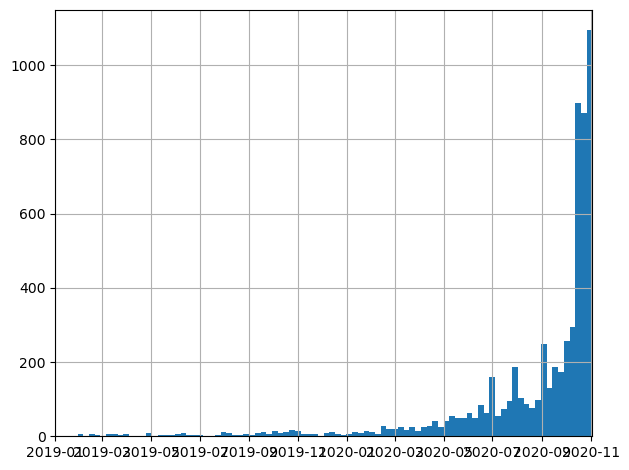

In [228]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2019, 1, 1), dt.datetime(2020, 11, 3))

plt.tight_layout()
plt.show()

In [229]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Probability Panel,IVR/Online Panel,IVR/Text,Live Phone/Online Panel,Text-to-Web/Online Ad,Online Ad,Online Panel/Text-to-Web,Online Panel/Online Ad
pollster,,,,,,,,,,,
All,6137,4036,729,415,165,117,111,107,57,51,50
SurveyMonkey,2843,2843,0,0,0,0,0,0,0,0,0
Morning Consult,468,467,1,0,0,0,0,0,0,0,0
USC Dornsife,214,0,0,214,0,0,0,0,0,0,0
Ipsos,191,1,0,190,0,0,0,0,0,0,0
YouGov,162,162,0,0,0,0,0,0,0,0,0
Change Research,111,2,0,0,0,0,0,107,2,0,0
Data for Progress,96,45,0,0,0,0,0,0,0,50,0
Redfield & Wilton Strategies,94,88,6,0,0,0,0,0,0,0,0


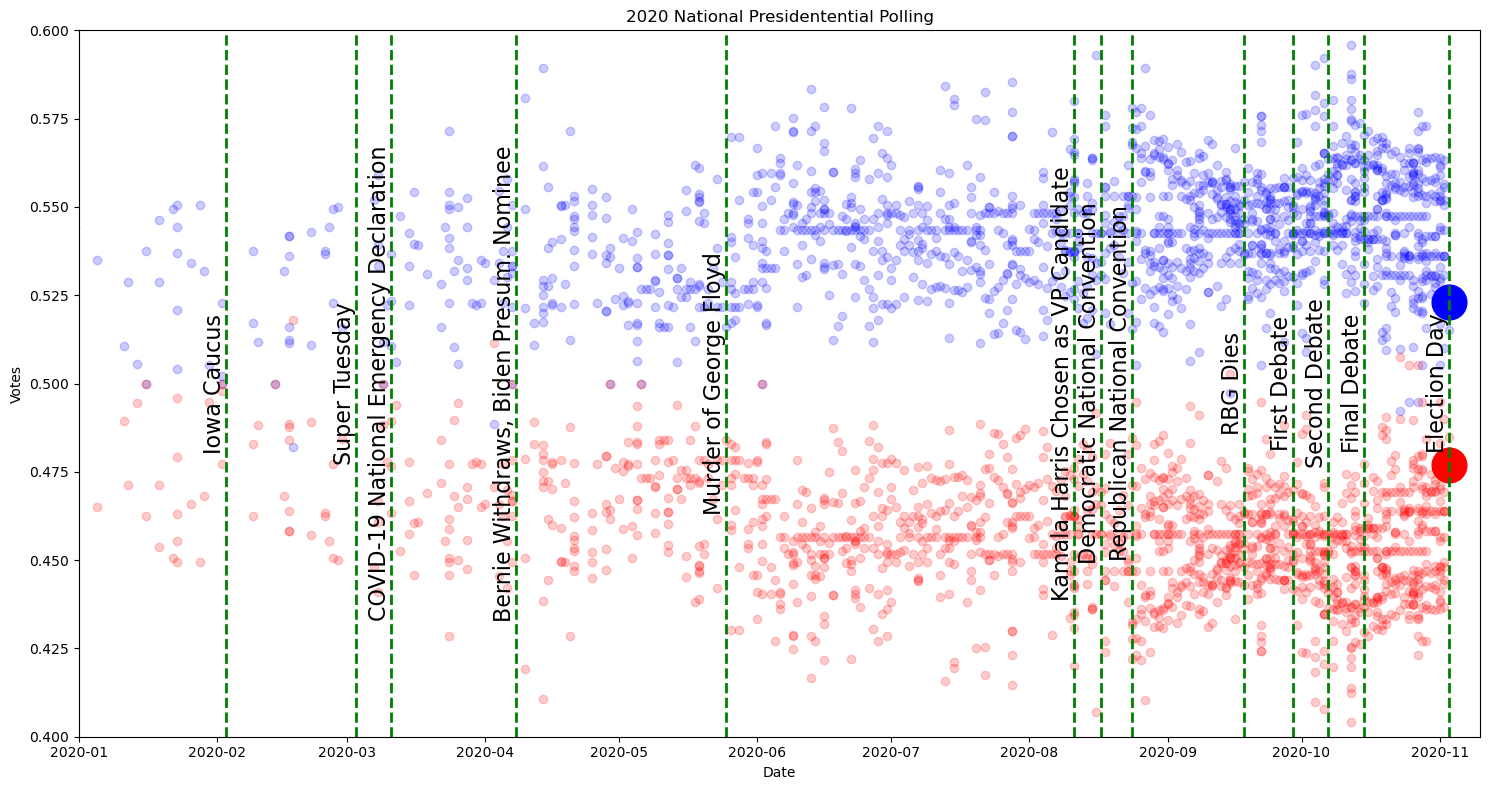

In [230]:
dem_votes = df_2way.query("state == 'US'")["DEM"].values
gop_votes = df_2way.query("state == 'US'")["GOP"].values

dates = df_2way.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.2, color='red', label="Trump")

# Set limits and labels
ax.set_ylim(0.4, 0.6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2020 National Presidentential Polling')

events = [
            (dt.datetime(2020, 3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020, 2, 3), 'Iowa Caucus'),
            (dt.datetime(2020, 3, 3), 'Super Tuesday'),
            (dt.datetime(2020, 4, 8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020, 5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020, 8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020, 8, 17), 'Democratic National Convention'),
            (dt.datetime(2020, 8, 24), 'Republican National Convention'),
            (dt.datetime(2020, 9, 18), 'Death of RBG'),
            (dt.datetime(2020, 9, 29), 'First Debate'),
            (dt.datetime(2020, 10, 7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11, 3), 'Election Day'),
         ]

# Add large blue dot at the final actual national popular vote for Biden
ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)

# Add large red dot at the final actual national popular vote for Trump
ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.5, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Daily standard deviation in polls')

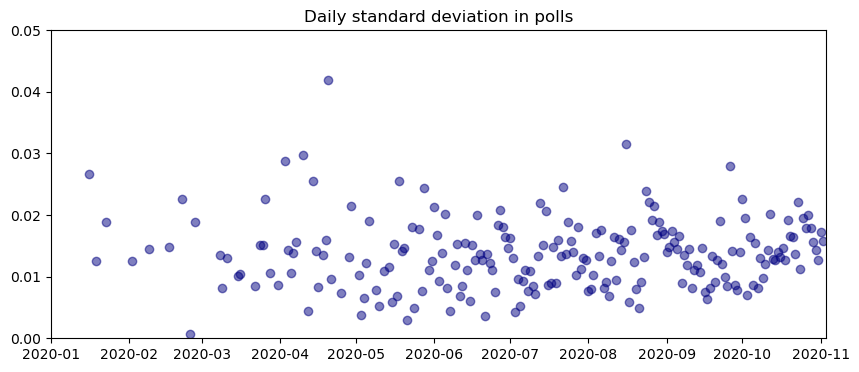

In [231]:
rolling_std = (
    df_2way.query("state == 'US'")[["date", "DEM", "GOP"]]
    .reset_index()
    .groupby(["date"])
    .std()
    .reset_index()[["date", "DEM", "GOP"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_std.date,
    rolling_std.DEM.values,
    "o",
    color = 'navy',
    alpha=0.5,
)

ax.set_ylim(0, .05)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3))
ax.set_title("Daily standard deviation in polls")

We can see here that polling methodology is irrelevant, they all perform about the same.

In [232]:
df.query("state == 'US'").query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'IVR/Online Panel', 'IVR/Text', 'Live Phone/Online Panel', 'Text-to-Web/Online Ad']")[['methodology','DEM','GOP']].groupby("methodology").mean()

,DEM,GOP
methodology,,
IVR/Online Panel,0.524968,0.475032
IVR/Text,0.542122,0.457878
Live Phone,0.548864,0.451136
Live Phone/Online Panel,0.533513,0.466487
Online Panel,0.539812,0.460188
Probability Panel,0.554086,0.445914
Text-to-Web/Online Ad,0.536276,0.463724


We can see that Trump fairly consistently out-performs on App Panel polls.

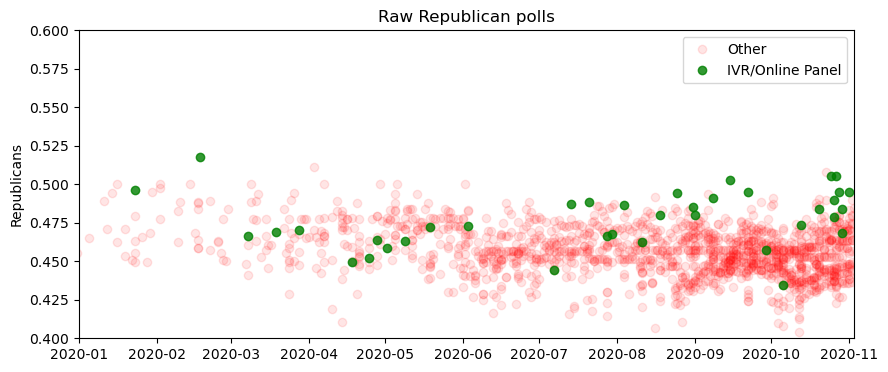

In [233]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "IVR/Online Panel"]
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "IVR/Online Panel"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["GOP"].values, "o", alpha=0.1, color = 'red', label="Other")
ax.plot(dates_face, face["GOP"].values, "o", alpha=.8, color = 'green', label="IVR/Online Panel")
ax.set_ylim(.4, .6)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3))
ax.legend()

In [234]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [235]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,type,obs_id,type_bt,margin,GOP_mean,DEM_mean,margin_mean,diff_GOP,diff_DEM,diff_margin
0,2020-11-03,73830,138491,940,Lake Research,Live Phone,US,lv,2376.0,2020,...,2way,0,1,0.03,0.48,0.52,0.03,0.00,0.00,0.00
1,2020-11-02,74946,142781,1677,The Political Matrix/The Listener Group,IVR,FL,lv,891.0,2020,...,2way,1,1,-0.04,0.48,0.52,0.05,0.05,-0.05,-0.09
2,2020-11-02,72621,136283,383,PPP,IVR/Text,IA,v,845.0,2020,...,2way,2,1,0.01,0.48,0.52,0.05,0.02,-0.02,-0.04
3,2020-11-02,72647,136322,461,Susquehanna,Live Phone,PA,lv,487.0,2020,...,2way,3,1,-0.01,0.48,0.52,0.05,0.03,-0.03,-0.06
4,2020-11-02,72722,136491,235,InsiderAdvantage,IVR/Live Phone,FL,lv,381.0,2020,...,2way,4,1,-0.01,0.48,0.52,0.05,0.03,-0.03,-0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6132,2019-02-01,57472,93051,1240,Øptimus,Live Phone,US,lv,916.0,2020,...,2way,6132,1,0.05,0.47,0.53,0.05,0.00,-0.00,-0.00
6133,2019-01-26,57427,92926,176,Glengariff Group Inc.,Live Phone,MI,lv,562.0,2020,...,2way,6133,1,0.14,0.43,0.57,0.14,0.00,0.00,0.00
6134,2019-01-21,57365,92773,383,PPP,IVR/Online Panel,US,rv,714.0,2020,...,2way,6134,1,0.13,0.44,0.56,0.13,0.00,0.00,0.00
6135,2019-01-07,57275,92597,383,PPP,IVR/Online Panel,NC,rv,698.0,2020,...,2way,6135,1,0.05,0.47,0.53,0.05,0.00,0.00,0.00


In [236]:
df.groupby('type')[['margin']].mean()

,margin
type,
2way,0.05869


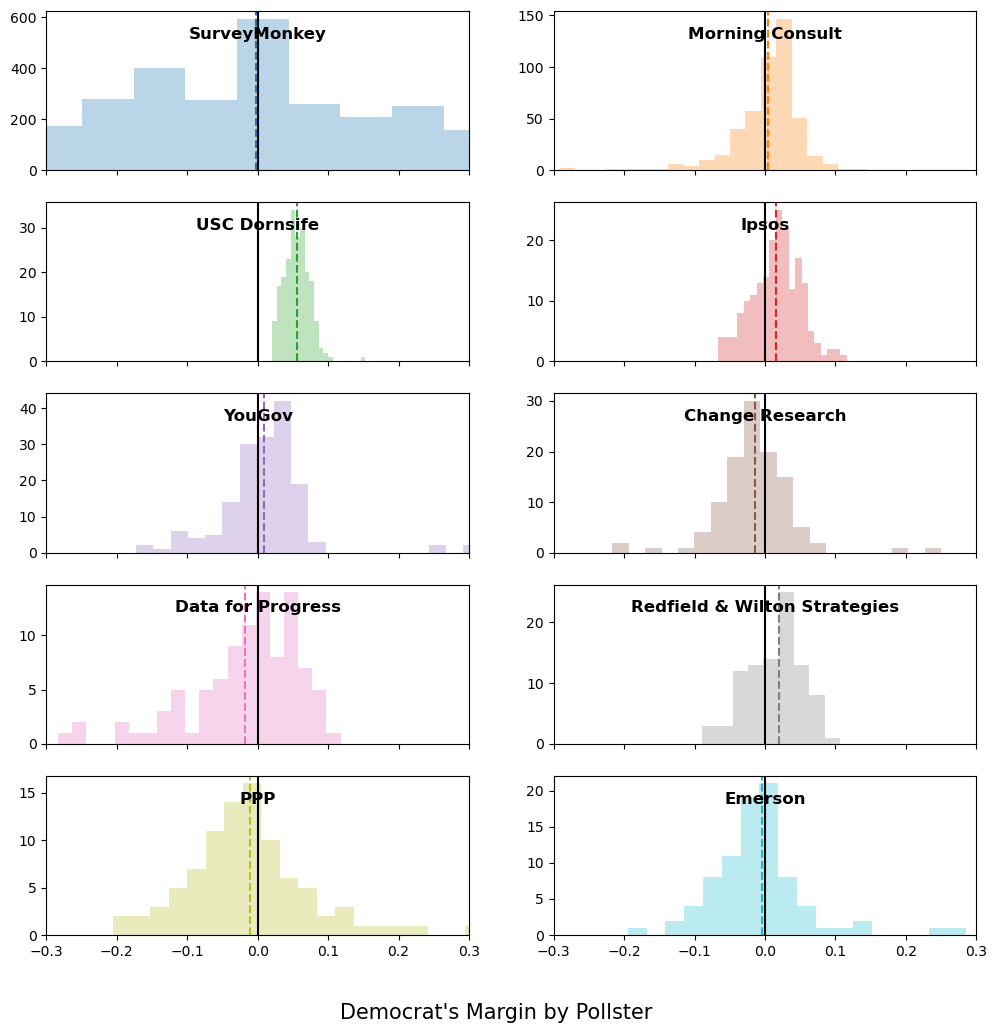

In [237]:
POLLSTER_VALS = {
    pollster: df[df["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.3, .3)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


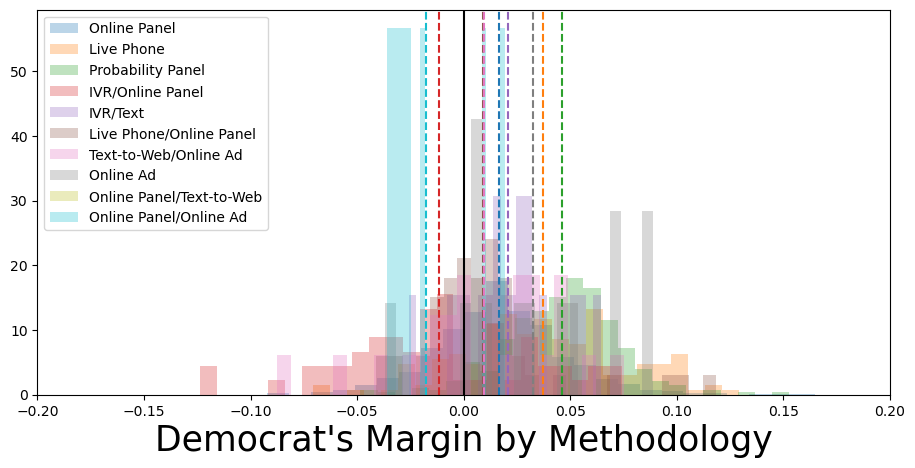

In [238]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in METHODS_top
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method, bins=25, density=True)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-.2, .2)
ax.set_xlabel(r"Democrat's Margin by Methodology", fontsize=25)
ax.legend();

In [356]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

day_id, day = df.set_index(
    ["day"]
).index.factorize(sort=True)

day = np.concatenate([day, np.arange(max(day))+1, 0)])

party_id, party = [0,1], ['DEM','GOP']

week = np.arange(min(week), 1)

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [357]:
with pm.Model(coords=COORDS) as pooled_popularity_simple:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_pop_effect = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")
    dem_day_effect = pm.GaussianRandomWalk("dem_day_effect", sigma=dem_sigma, init_dist=pm.Normal.dist(mu=-0.025, sigma=0.1), dims="day")

    dem_polling = pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_state_effect[state_id] +
        dem_pop_effect[population_id] +
        dem_day_effect[day_id]
    )

    dem_vote = pm.Binomial(
        "dem_vote",
        p=dem_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['DEM'],
        dims="observation",
    )

    # Sampling
    idata = pm.sample(draws=100, cores=4, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dem_sigma, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_pop_effect, dem_day_effect]


Output()

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 569 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [358]:
z = pd.DataFrame()
z['day'] = idata.posterior.day
z['day_effect'] = idata.posterior.dem_day_effect.mean(axis=0).mean(axis=0).values

In [387]:
idata.posterior.day

<xarray.DataArray 'day' (day: 442)> Size: 4kB
array([-687, -666, -652, ...,   -2,   -1,    0])
Coordinates:
  * day      (day) int64 4kB -687 -666 -652 -647 -641 -640 ... -5 -4 -3 -2 -1 0

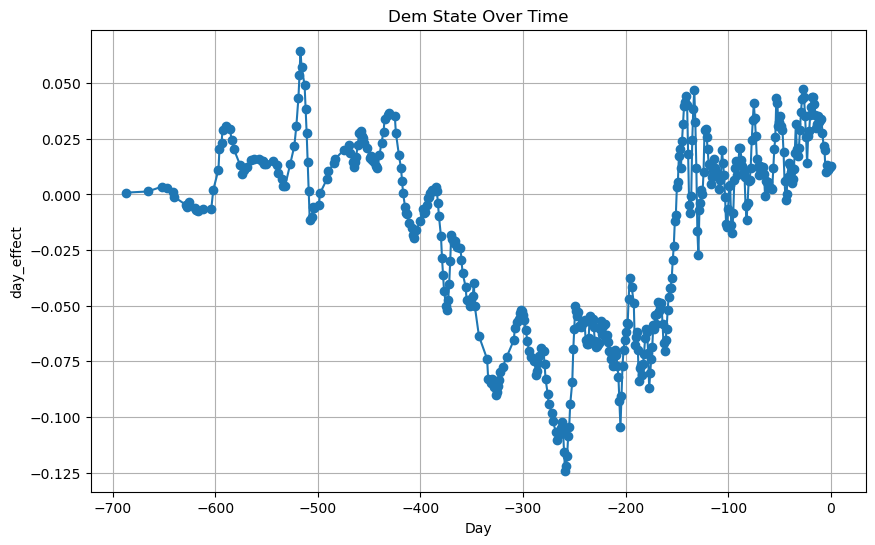

In [359]:
plt.figure(figsize=(10, 6))
plt.plot(z['day'], z['day_effect'], marker='o', linestyle='-')
plt.xlabel('Day')
plt.ylabel('day_effect')
plt.title('Dem State Over Time')
plt.grid(True)
plt.show()

In [372]:
states = df['state'].unique()
parties = ['dem','gop', 'margin']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [377]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

for d in tqdm(day):
    for state in states:
        for party in ['dem']:
            df_results[f"{state}_{party}"] = inv_logit(
                idata.posterior[f"{party}_pollster_effect"].sel(pollster="Morning Consult") +
                idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}") +
                idata.posterior[f"{party}_pop_effect"].sel(population="rv") + #Registered voters
                idata.posterior[f"{party}_day_effect"].sel(day=d)
              ).values.ravel()
                
        df_results[f"{state}_gop"] = 1 - df_results[f"{state}_dem"]
        df_results[f"{state}_margin"] = df_results[f"{state}_dem"] - df_results[f"{state}_gop"]

    df_day_mean.loc[d] = df_results.mean()
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 442/442 [01:30<00:00,  4.90it/s]


In [378]:
df_day_mean['Date'] = df.date.unique()
df_day_03['Date'] = df.date.unique()
df_day_97['Date'] = df.date.unique()

df_day_mean = df_day_mean.reset_index().set_index('Date')
df_day_03 = df_day_03.reset_index().set_index('Date')
df_day_97 = df_day_97.reset_index().set_index('Date')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_1572/1200358032.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Democrats 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_1572/1200358032.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.

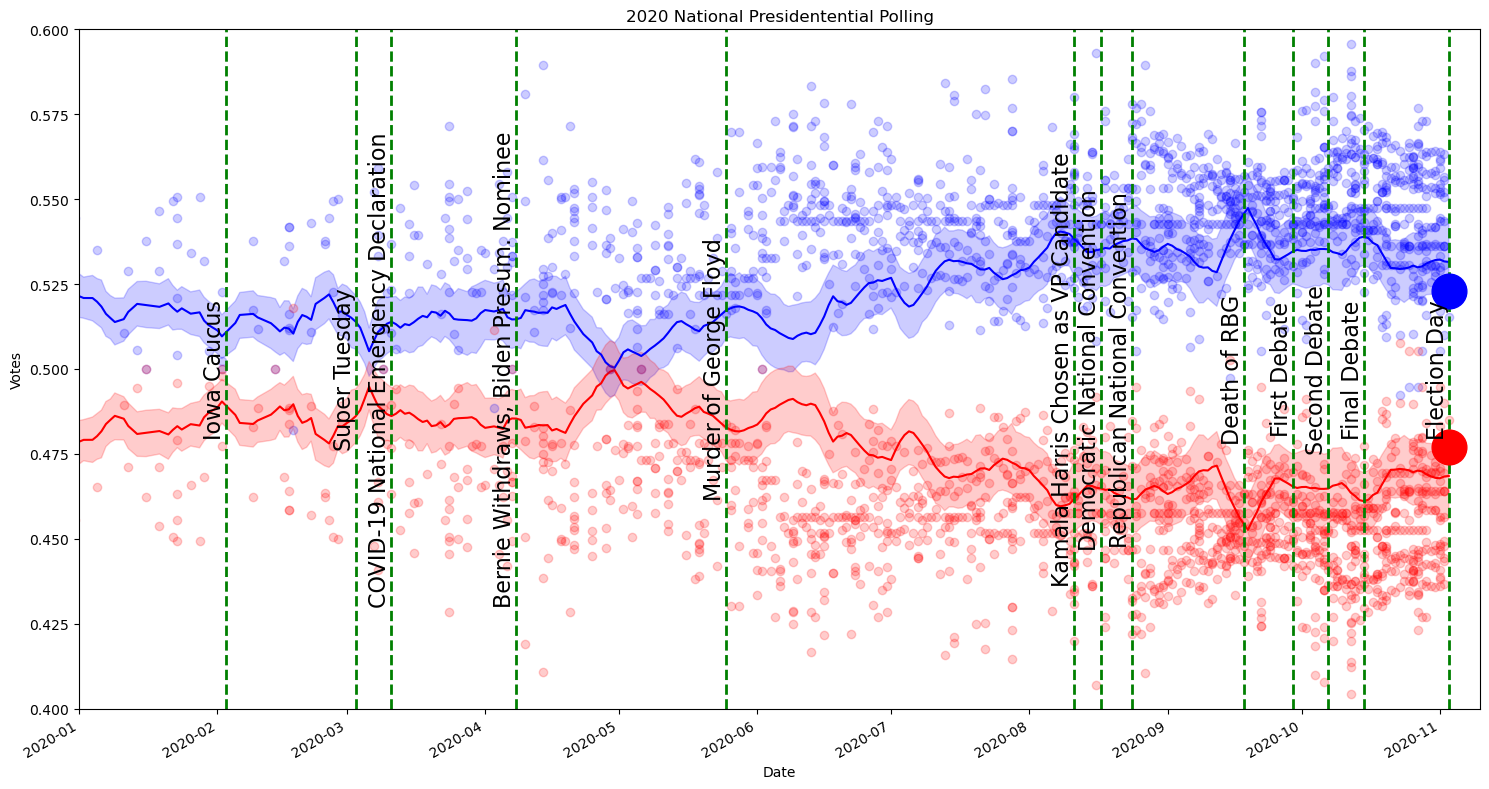

In [383]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Democrats 94% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='Republicans 94% HDI')

dem_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["GOP"]

dates = df_2way.query(f"state == '{graph_state}'").set_index('date').index

ax.plot(dem_votes.index, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(gop_votes.index, gop_votes, "o", alpha=0.2, color='red', label="Trump")

# Set limits and labels
ax.set_ylim(0.4, 0.6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2020 National Presidentential Polling')

events = [
            (dt.datetime(2020, 3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020, 2, 3), 'Iowa Caucus'),
            (dt.datetime(2020, 3, 3), 'Super Tuesday'),
            (dt.datetime(2020, 4, 8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020, 5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020, 8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020, 8, 17), 'Democratic National Convention'),
            (dt.datetime(2020, 8, 24), 'Republican National Convention'),
            (dt.datetime(2020, 9, 18), 'Death of RBG'),
            (dt.datetime(2020, 9, 29), 'First Debate'),
            (dt.datetime(2020, 10, 7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11, 3), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.5, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.show()

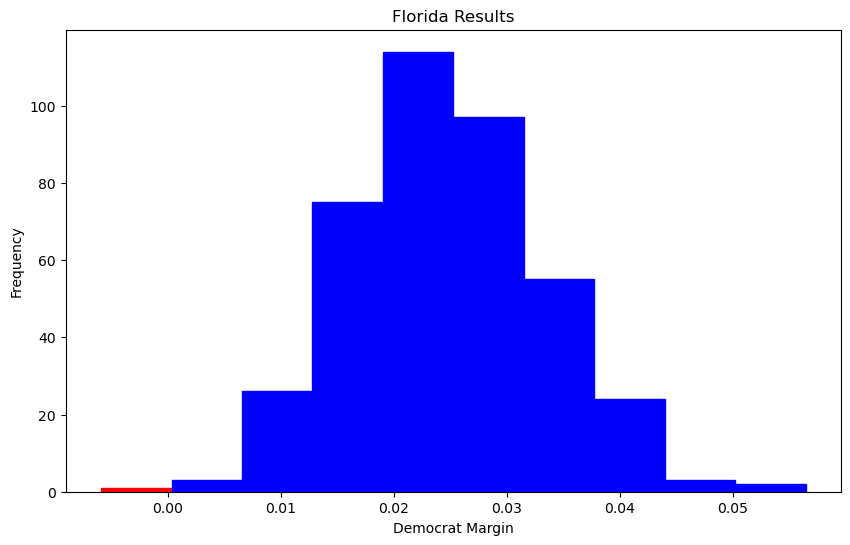

In [384]:
# Plotting the histograms
plt.figure(figsize=(10, 6))

ax = df_results['GA_margin'].plot.hist(bins = 10)

for bar in ax.containers[0]:
    # get x midpoint of bar
    x = bar.get_x() + 0.5 * bar.get_width()

    # set bar color based on x
    if x < 0:
        bar.set_color('red')
    elif x > 0:
        bar.set_color('blue')
    else:
        bar.set_color('green')

# Adding titles and labels
plt.title('Florida Results')
plt.xlabel('Democrat Margin')
plt.ylabel('Frequency')

# Display the plot
plt.show()


In [250]:
df_results

,US_dem,FL_dem,IA_dem,PA_dem,NV_dem,GA_dem,SC_dem,NE-2_dem,MT_dem,ME_dem,...,CA_gop,CA_margin,AR_gop,AR_margin,AL_gop,AL_margin,AK_gop,AK_margin,NE-1_gop,NE-1_margin
0,0.443009,0.412993,0.403165,0.437969,0.423909,0.420969,0.373902,0.422030,0.369180,0.474768,...,0.453302,0.093397,0.683774,-0.367548,0.683134,-0.366268,0.638333,-0.276665,0.553421,-0.106842
1,0.439775,0.409192,0.401413,0.434771,0.422819,0.419706,0.371108,0.426217,0.363904,0.472690,...,0.456258,0.087483,0.685964,-0.371927,0.685752,-0.371503,0.641478,-0.282956,0.573564,-0.147127
2,0.438338,0.408225,0.400719,0.434758,0.423609,0.418499,0.367942,0.426923,0.363793,0.470348,...,0.457671,0.084659,0.684811,-0.369623,0.687791,-0.375582,0.642480,-0.284960,0.580303,-0.160606
3,0.442827,0.412944,0.407158,0.437178,0.424457,0.421467,0.373156,0.435680,0.374918,0.476686,...,0.453598,0.092805,0.685360,-0.370719,0.686309,-0.372618,0.635771,-0.271541,0.587439,-0.174878
4,0.443093,0.412556,0.402728,0.438245,0.428800,0.422996,0.372639,0.430079,0.370955,0.475262,...,0.452917,0.094166,0.681132,-0.362264,0.681040,-0.362080,0.630705,-0.261410,0.579858,-0.159716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.520992,0.489739,0.481692,0.516682,0.505272,0.499140,0.445365,0.517111,0.451712,0.554770,...,0.376837,0.246326,0.613624,-0.227248,0.611474,-0.222949,0.563229,-0.126458,0.507768,-0.015537
396,0.523366,0.492154,0.481793,0.518382,0.506109,0.501258,0.453647,0.506180,0.449277,0.555361,...,0.375830,0.248340,0.612709,-0.225417,0.612551,-0.225103,0.555713,-0.111427,0.505723,-0.011445
397,0.500866,0.469723,0.464174,0.495637,0.485375,0.476554,0.428269,0.491032,0.428393,0.533481,...,0.396677,0.206645,0.632354,-0.264708,0.630515,-0.261030,0.577492,-0.154984,0.547619,-0.095238
398,0.507952,0.477778,0.471948,0.503742,0.494055,0.486263,0.434901,0.500753,0.436085,0.542388,...,0.389397,0.221206,0.623173,-0.246347,0.624676,-0.249353,0.569167,-0.138334,0.554384,-0.108767


In [251]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [252]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['margin'] = df_margin.mean()

In [253]:
df_mean.sort_values('margin')

,dem,gop,margin
WY,0.306182,0.693818,-0.387635
WV,0.314806,0.685194,-0.370387
ND,0.375764,0.624236,-0.248472
OK,0.378552,0.621448,-0.242896
AL,0.381024,0.618976,-0.237953
ID,0.381201,0.618799,-0.237597
AR,0.382102,0.617898,-0.235796
MS,0.392347,0.607653,-0.215307
KY,0.392770,0.607230,-0.214460
LA,0.394655,0.605345,-0.210690


In [122]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [126]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [123]:
# Load US states shapefile (assuming it's available in GeoPandas datasets)
usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set the index of the shapefile to match state names (or two-letter postal codes)
usa.set_index('iso_a2', inplace=True)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_95191/2690937134.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


KeyError: "None of ['iso_a2'] are in the columns"

In [124]:
usa

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [ ]:
merged = usa.join(df, how='inner')


In [ ]:
df_post = pd.DataFrame()
df_post['mean_dem'] = idata.posterior['dem_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_gop'] = idata.posterior['gop_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_ind'] = idata.posterior['ind_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_oth'] = idata.posterior['oth_state_effect'].mean(axis=0).mean(axis=0).values
df_post['state'] = idata.posterior['dem_state_effect'].state.values

df_post.groupby('state').mean()

<Axes: xlabel='president'>

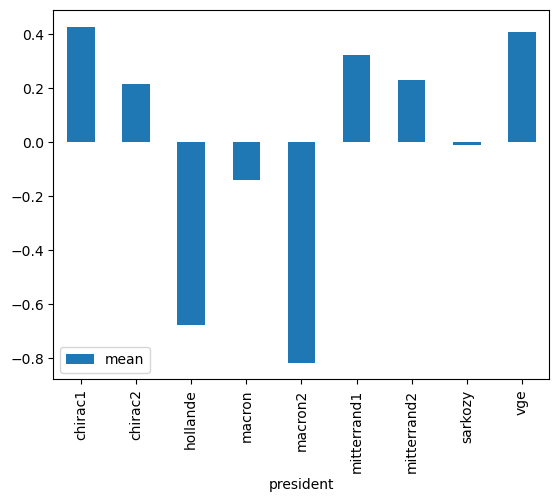

In [19]:
df = pd.DataFrame()

df = pd.DataFrame()
df['mean'] = idata.posterior['president_effect'].mean(axis=0).mean(axis=0).values
df['president'] = idata.posterior['president_effect'].president.values

df.groupby('president').mean().plot(kind="bar")

<Axes: xlabel='week'>

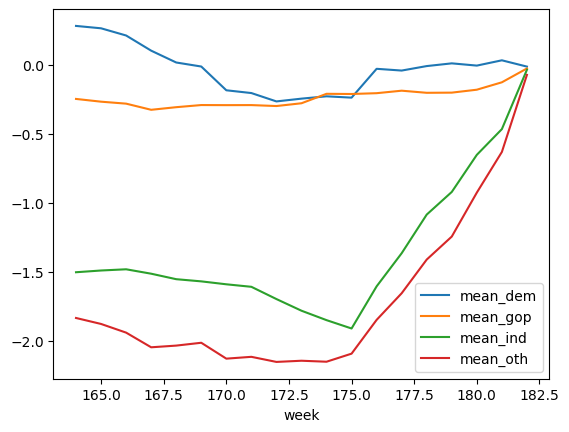

In [1207]:
df_post = pd.DataFrame()
df_post['mean_dem'] = idata.posterior['dem_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_gop'] = idata.posterior['gop_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_ind'] = idata.posterior['ind_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_oth'] = idata.posterior['oth_week_effect'].mean(axis=0).mean(axis=0).values
df_post['week'] = idata.posterior.week.values

df_post.groupby('week').mean().plot()

In [960]:
def plot_latent_mu(inference_data, overlay_observed=True):
    """Plot latent posterior popularity"""
    post_pop = logistic(
        inference_data.posterior["dem_week_effect"].stack(sample=("chain", "draw"))
    )

    fig, ax = plt.subplots()

    # plot random posterior draws
    ax.plot(
        inference_data.posterior.coords["week"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )

    # plot posterior mean
    post_pop.mean("sample").plot(ax=ax, color="black", lw=2, label="predicted mean")

    ax.set_xlabel("Months into term")
    ax.set_ylabel("Does approve")
    ax.legend()

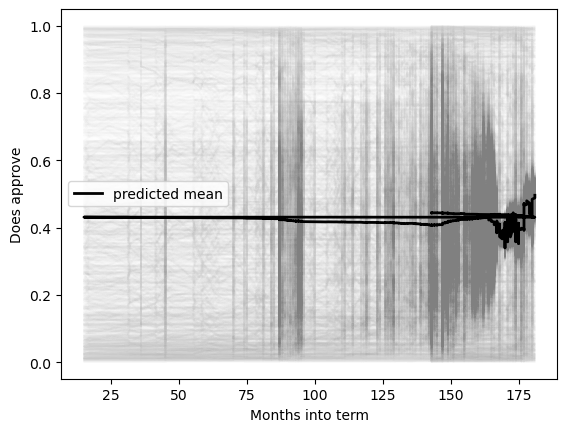

In [961]:
plot_latent_mu(idata)

In [23]:
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: float = 1.0,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters

    name: str
        String name representation of the PyMC variable.
    sigma: float, defaults to 1
        Scale for the Normal distribution. If none is provided, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.

    Notes
-   ----------
    Contributed by Adrian Seyboldt (@aseyboldt).
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncated_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncated_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncated_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_hh(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

COORDS["month_minus_origin"] = COORDS["month"][1:]

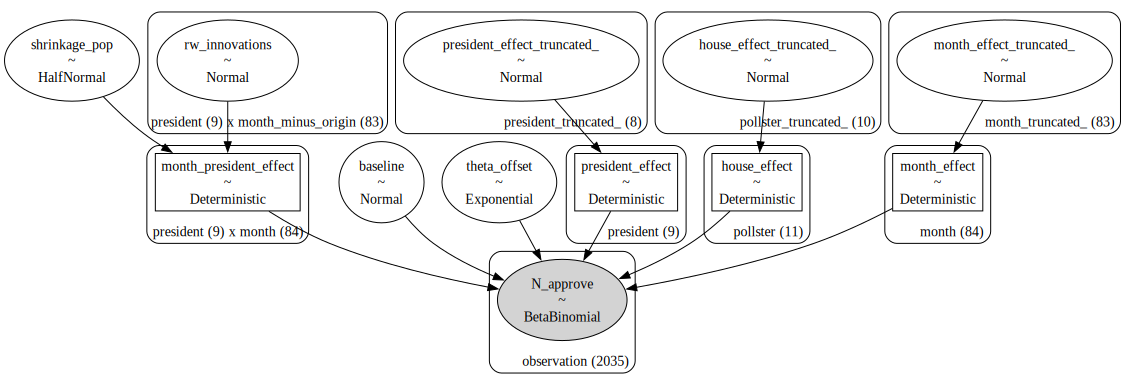

In [24]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = ZeroSumNormal("president_effect", sigma=0.15, dims="president")
    house_effect = ZeroSumNormal("house_effect", sigma=0.15, dims="pollster")
    month_effect = ZeroSumNormal("month_effect", sigma=0.15, dims="month")

    # need the cumsum parametrization to properly control the init of the GRW
    rw_init = aet.zeros(shape=(len(COORDS["president"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("president", "month_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.Deterministic(
        "month_president_effect", raw_rw * sd, dims=("president", "month")
    )

    popularity = pm.math.invlogit(
        baseline
        + president_effect[president_id]
        + month_effect[month_id]
        + month_president_effect[president_id, month_id]
        + house_effect[pollster_id]
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_approve = pm.BetaBinomial(
        "N_approve",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )
pm.model_to_graphviz(hierarchical_popularity)

In [25]:
with hierarchical_popularity:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, president_effect_truncated_, house_effect_truncated_, month_effect_truncated_, rw_innovations, shrinkage_pop, theta_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 267 seconds.


/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


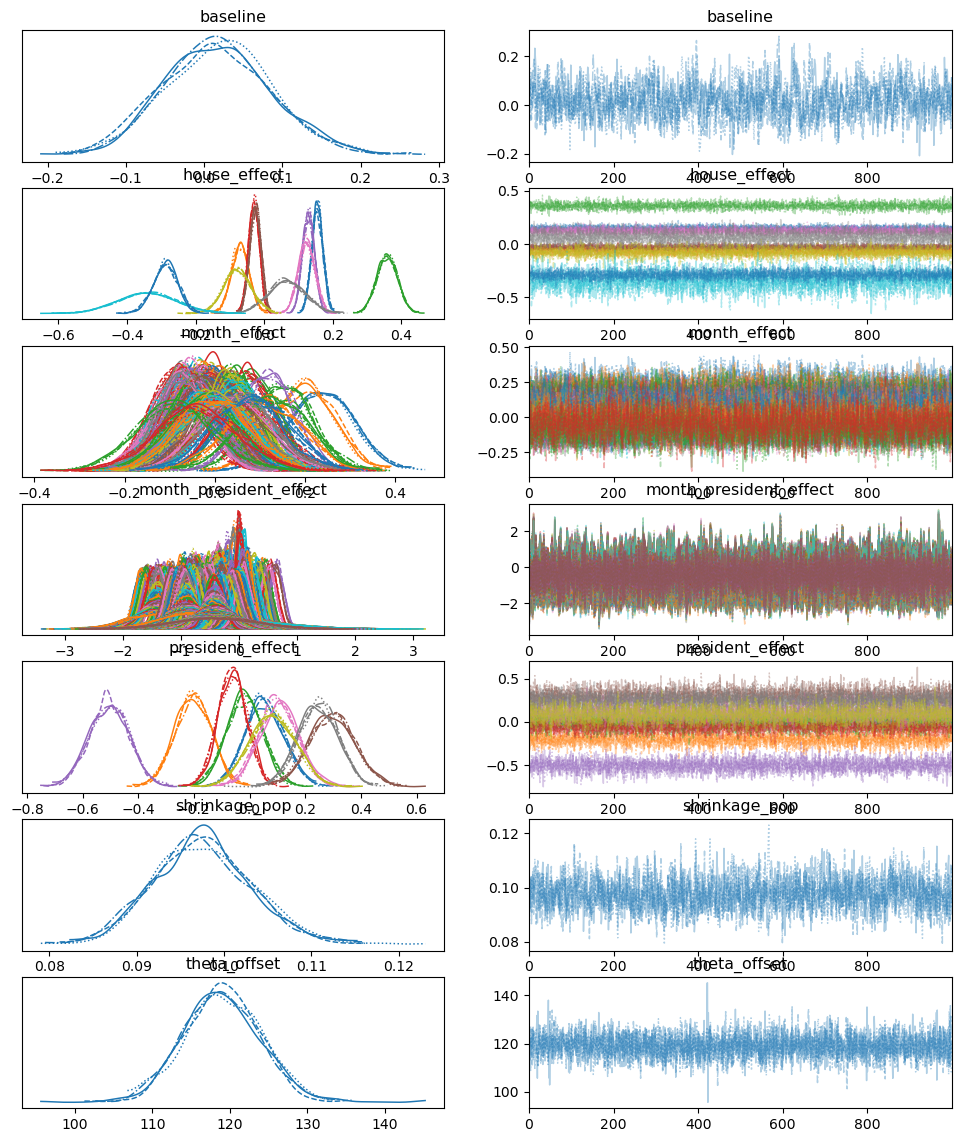

In [26]:
arviz.plot_trace(
    idata,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
    compact=True,
);

In [27]:
arviz.summary(
    idata,
    round_to=2,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (n

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,0.02,0.07,-0.11,0.15,0.00,0.00,894.76,1653.80,1.0
house_effect[BVA],0.16,0.02,0.13,0.19,0.00,0.00,2700.10,2782.97,1.0
house_effect[Elabe],-0.07,0.03,-0.12,-0.02,0.00,0.00,4202.10,3294.66,1.0
house_effect[Harris],0.36,0.03,0.30,0.41,0.00,0.00,4574.67,3096.85,1.0
house_effect[Ifop],-0.03,0.02,-0.06,-0.00,0.00,0.00,2039.60,2604.14,1.0
...,...,...,...,...,...,...,...,...,...
president_effect[mitterrand2],0.10,0.07,-0.03,0.23,0.00,0.00,3553.36,2782.25,1.0
president_effect[sarkozy],0.25,0.07,0.12,0.38,0.00,0.00,3302.49,2867.73,1.0
president_effect[vge],0.08,0.08,-0.07,0.23,0.00,0.00,3841.99,3203.38,1.0
shrinkage_pop,0.10,0.01,0.09,0.11,0.00,0.00,1359.82,2468.22,1.0


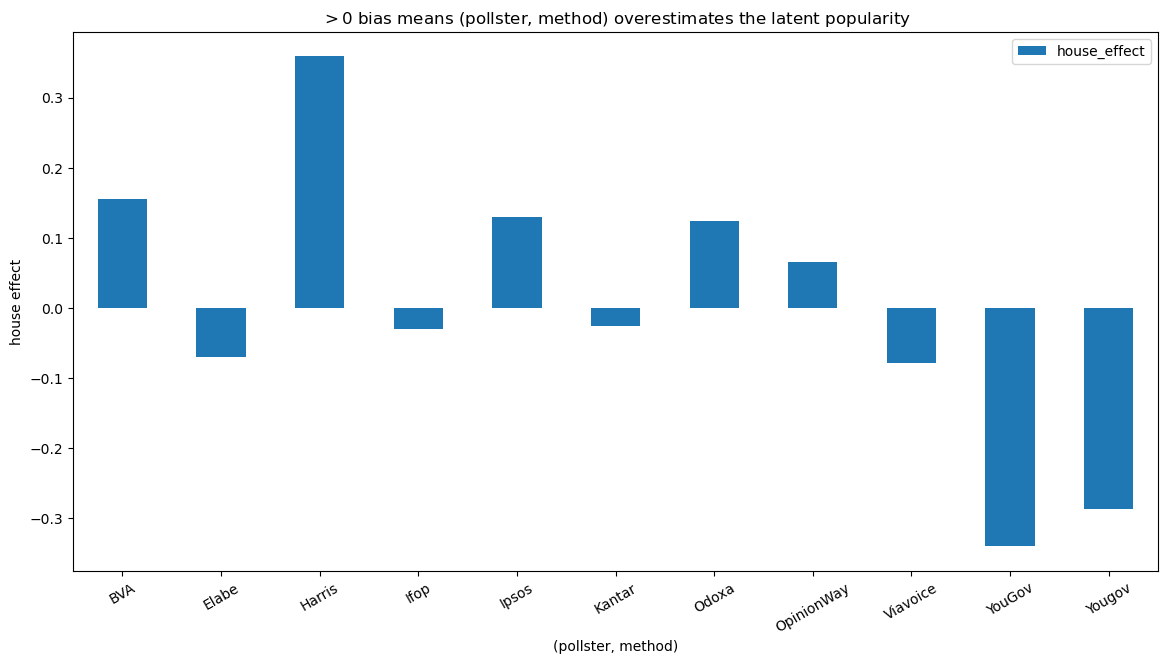

In [28]:
mean_house_effect = (
    idata.posterior["house_effect"].mean(("chain", "draw")).to_dataframe()
)
ax = mean_house_effect.plot.bar(figsize=(14, 7), rot=30)
ax.set_xlabel("(pollster, method)")
ax.set_ylabel("house effect")
ax.set_title("$>0$ bias means (pollster, method) overestimates the latent popularity");


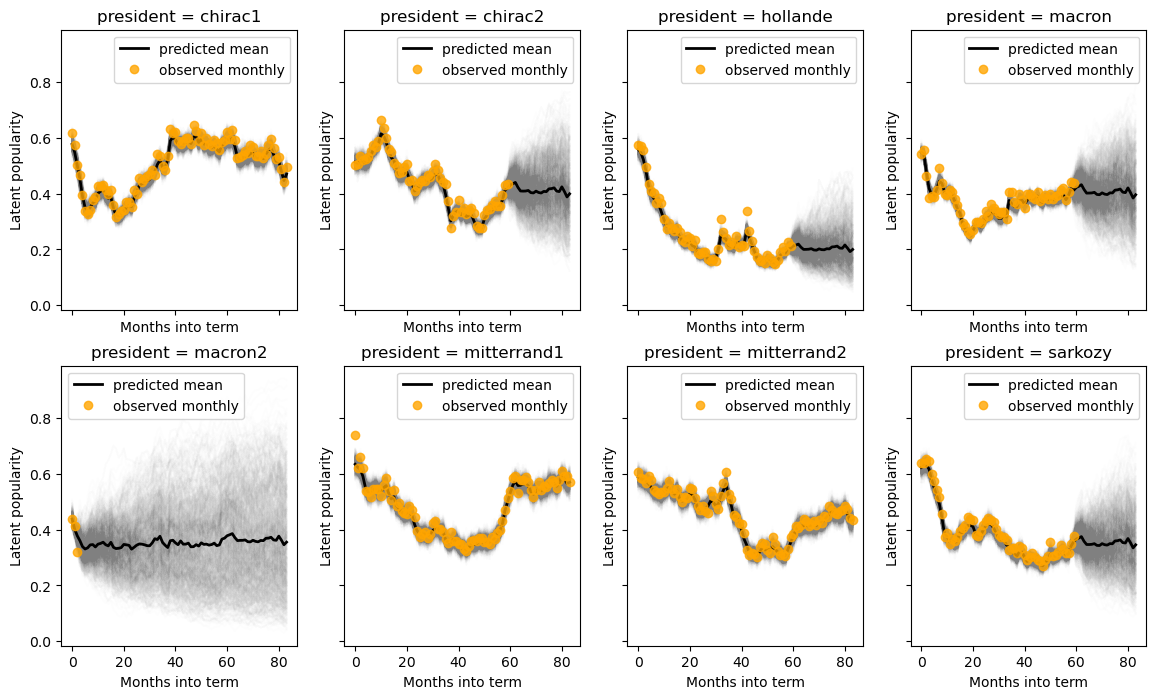

In [29]:
obs_mean = (data.groupby(["president", "month_id"]).last()["approve_pr_mean"]/100).unstack().T

fig, axes = plt.subplots(2, 4, figsize=(14, 8), sharex=True, sharey=True)

for ax, p in zip(axes.ravel(), idata.posterior.coords["president"]):
    post = idata.posterior.sel(president=p)
    post_pop = logistic(
        (
            post["baseline"]
            + post["president_effect"]
            + post["month_effect"]
            + post["month_president_effect"]
        ).stack(sample=("chain", "draw"))
    )
    # plot random posterior draws
    ax.plot(
        post.coords["month"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )
    # plot posterior mean
    post_pop.mean("sample").plot(ax=ax, color="black", lw=2, label="predicted mean")
    # plot monthly raw polls
    ax.plot(
        obs_mean.index,
        obs_mean[p.data],
        "o",
        color="orange",
        alpha=0.8,
        label="observed monthly",
    )
    ax.set_xlabel("Months into term")
    ax.set_ylabel("Latent popularity")
    ax.legend()